# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# # PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# # FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('se_resnext50_3lr_1e-3_imagenetch3')

TH = 40.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 33.9 s, sys: 29.4 s, total: 1min 3s
Wall time: 6.71 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('TH', 24),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

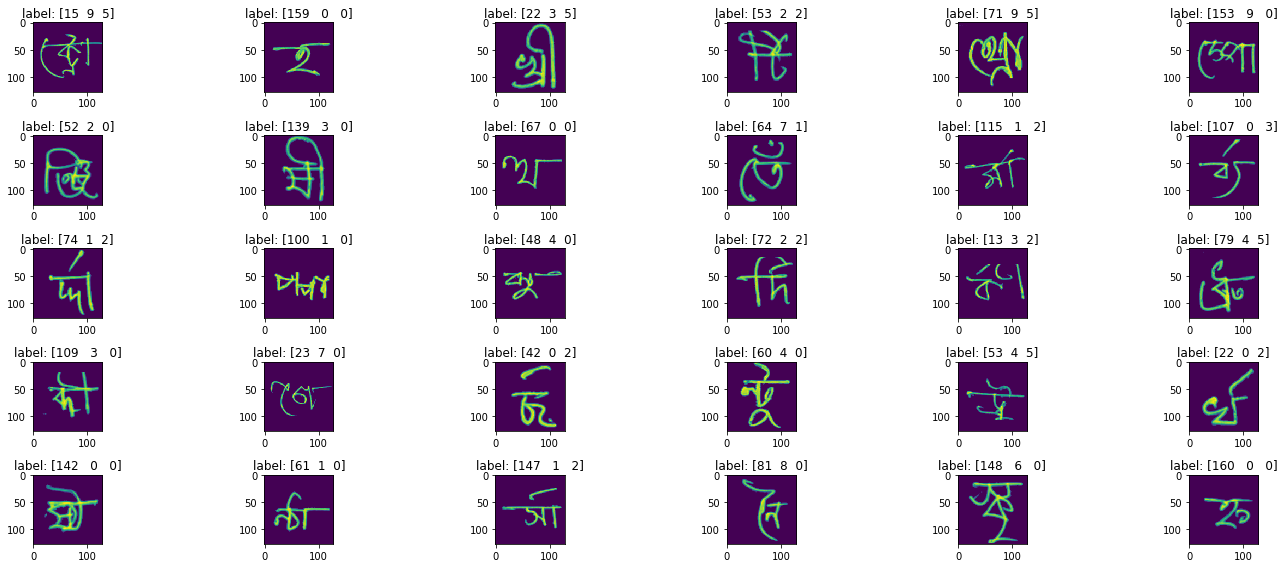

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.15
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def crop_char_image_new(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0 > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

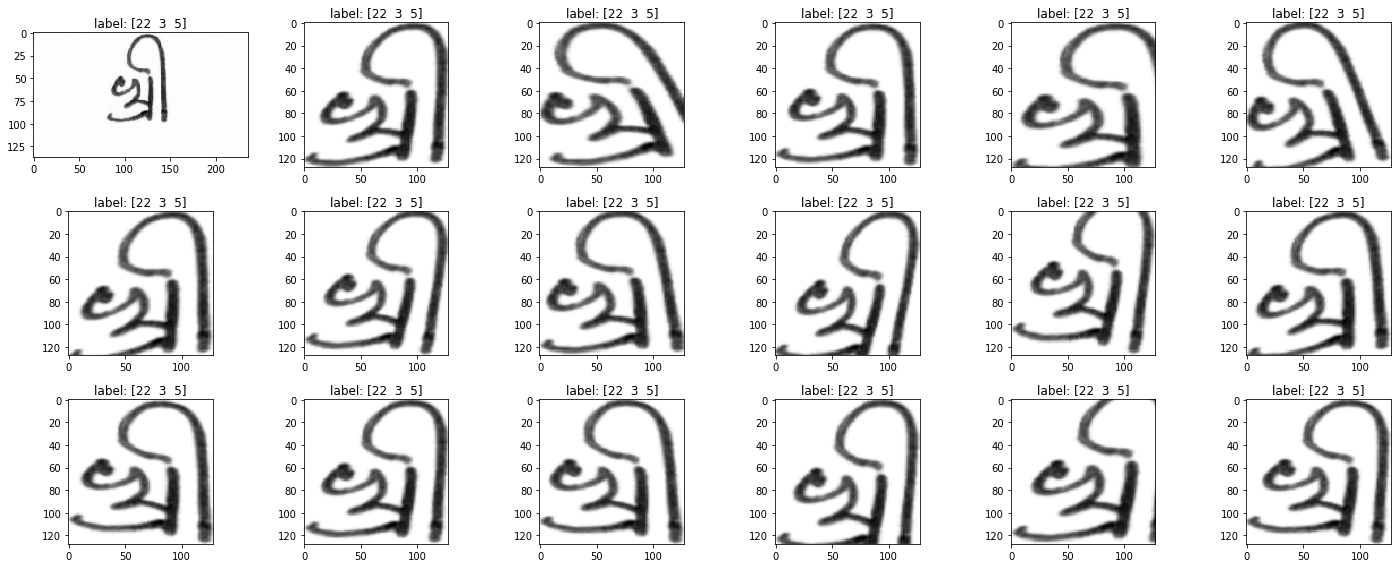

In [19]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

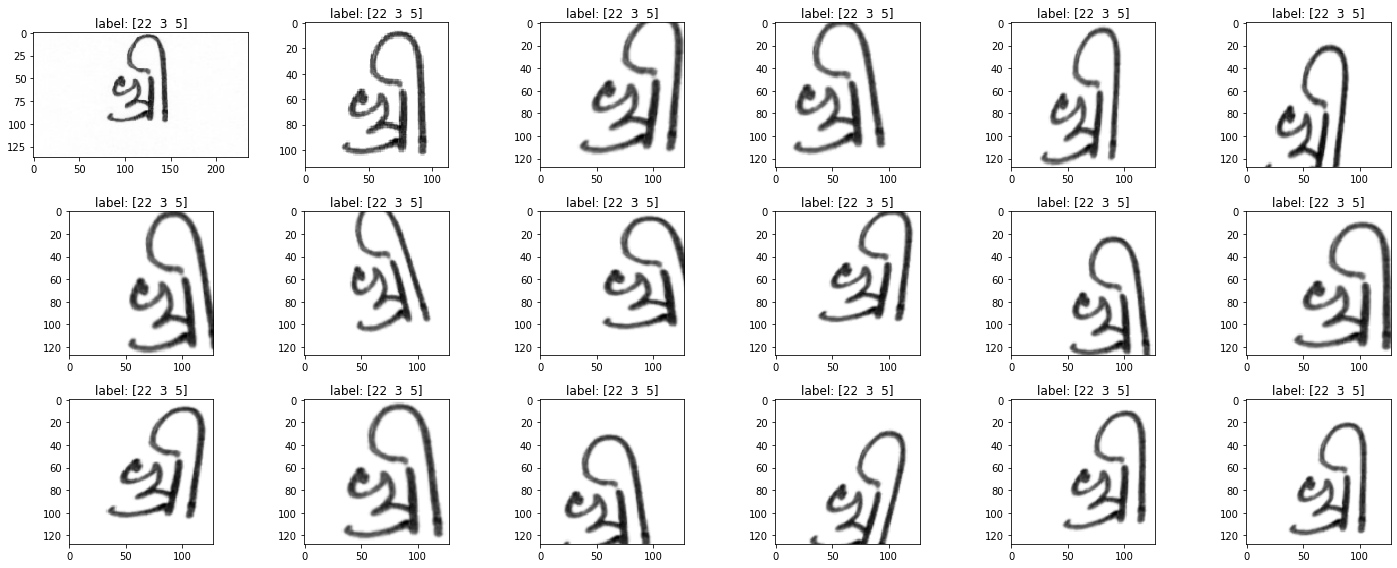

In [20]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
PAD = 20
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[2]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    elif i==1:
        ax.imshow(crop_char_image(image), cmap='Greys')
    else:
        ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

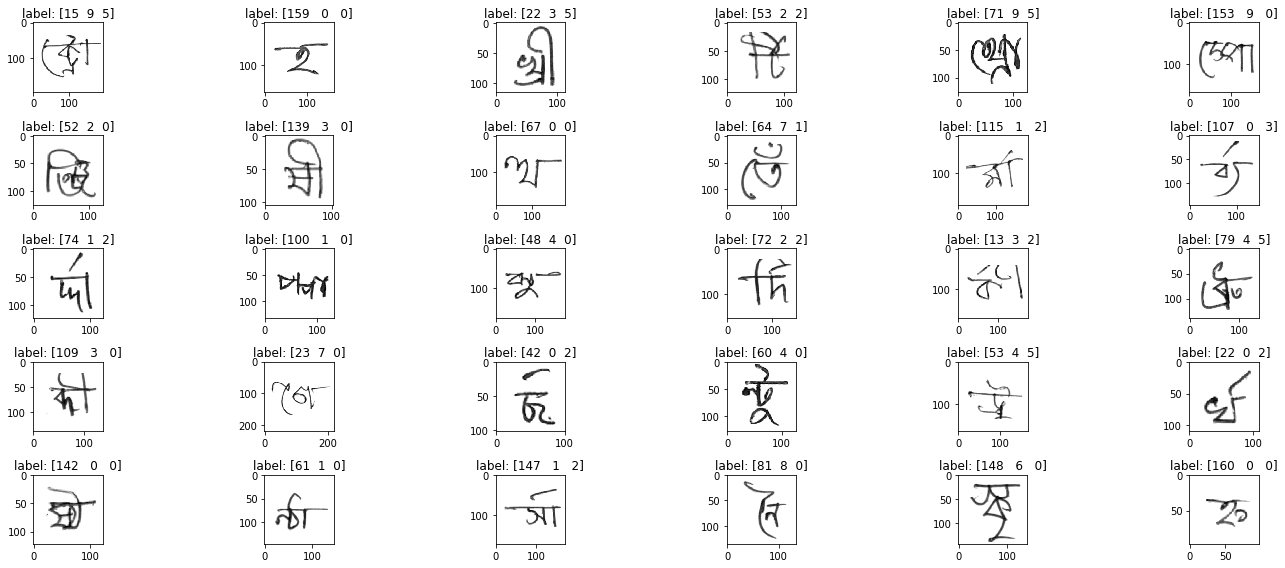

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

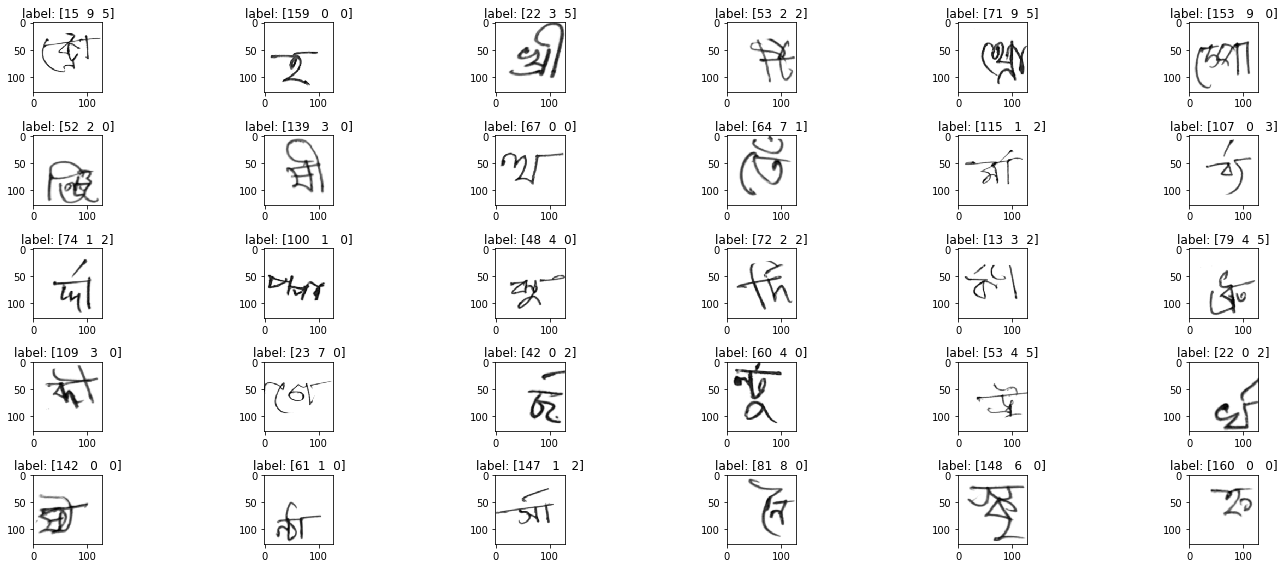

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.5:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
            else:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=32, max_w_size=32, p=1.0),x)  # Deprecated...

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [24]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
    piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

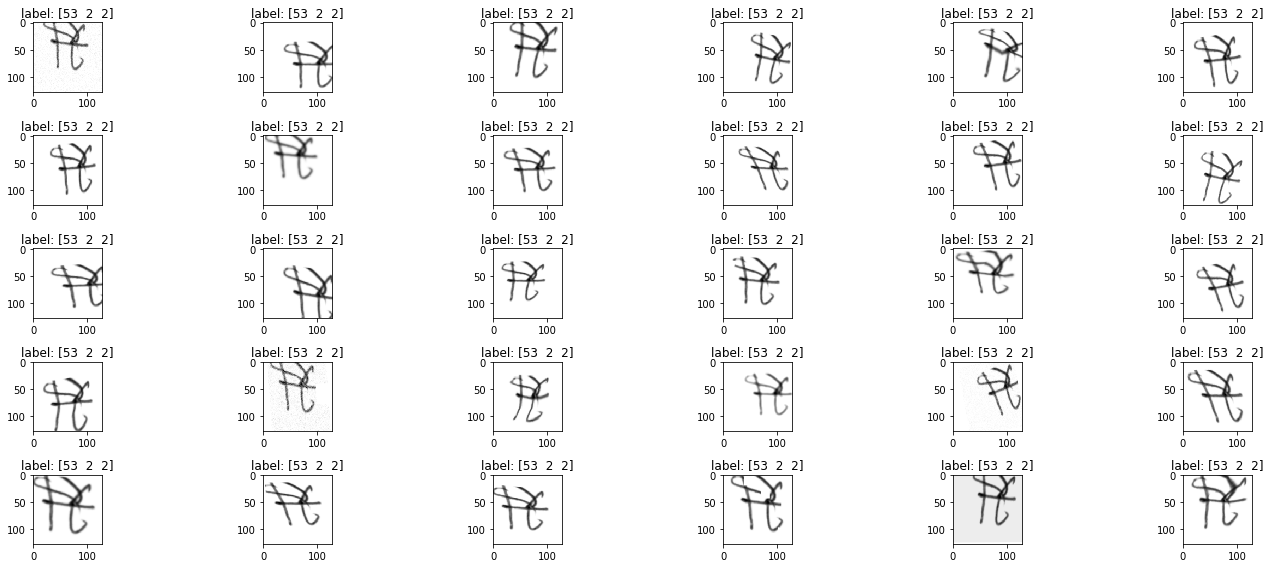

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[3]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

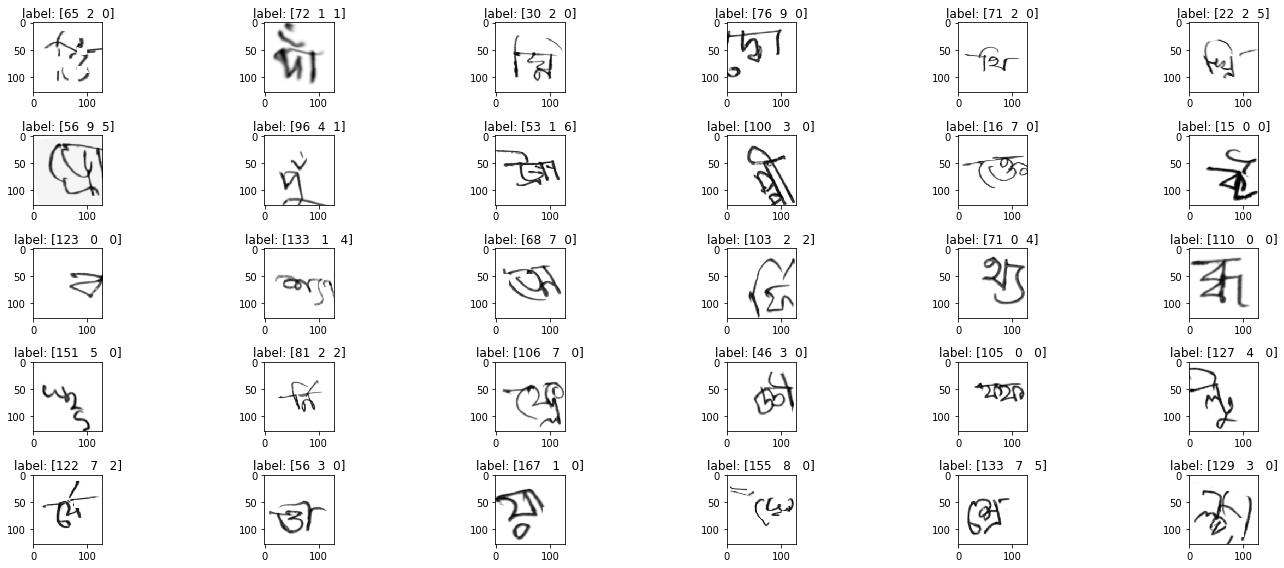

In [26]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

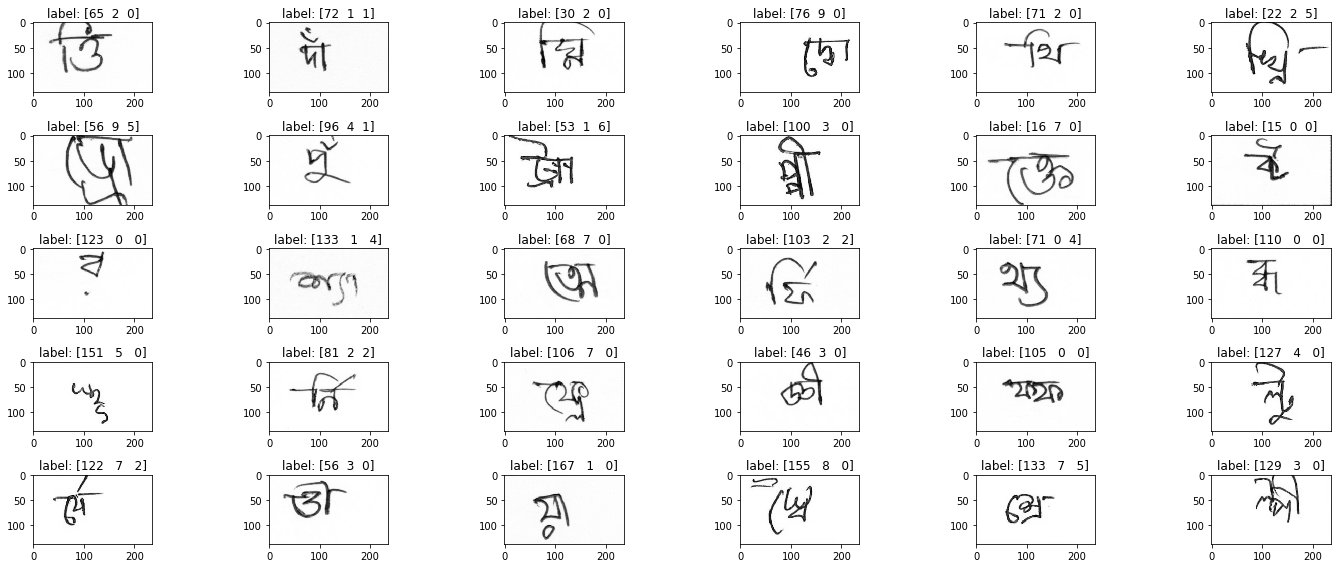

In [27]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i+100]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [28]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [29]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [30]:
a = np.array([2,3])
b = np.array([4,5,6])

In [31]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [32]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [33]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, out = 1000, dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        return x

In [34]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [35]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [36]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [37]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet', dropout_ratio=0.1):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
#         print(self.base_model)
        names = []
        for name, child in self.base_model.named_children():
            names.append(name)
            
        arch = self.base_model
        arch = list(arch.children())
        #saving the weights of the forst conv in w
        w = arch[0][0].weight
        #creating new Conv2d to accept 1 channel 
        arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #substituting weights of newly created Conv2d with w from but we have to take mean
        #to go from  3 channel to 1
        arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
        arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
#         print(arch)
        self.base_model = arch
#         print("#######################################")
#         print(self.base_model)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        
        hdim = 1024
        self.classifer = ClassifierNew(inp = inch, h1=hdim, out = out_dim, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.base_model.layer0(x)
        h = self.base_model.layer1(h)
        h = self.base_model.layer2(h)
        h = self.base_model.layer3(h)
        h = self.base_model.layer4(h)
        
        h = self.classifer(h)

        return h

In [38]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [39]:
# print_grad_status(predictortmp)

In [40]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [41]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [42]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [43]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [44]:
predictortmp = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
for name, child in predictortmp.named_children():
    print(name)
print_base_layers(predictortmp)

base_model
classifer
base model layer names::
layer0
layer1
layer2
layer3
layer4
avg_pool
last_linear


In [45]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.base_model.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-6)
    lr_10 = max(learning_rate/10, 5e-6)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
        dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
        dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
        dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
        dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
        dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
        dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [46]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = 0.5*F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = 0.25*F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = 0.25*F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [47]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [48]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [49]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [50]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [51]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [52]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [53]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [54]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [55]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [56]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [57]:
def save_params(outdir, k, img_size, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [58]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained="imagenet")
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
#     optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-4)
    optimizer = get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  1.059543 train/loss_grapheme  0.815079 train/loss_vowel  0.137914 train/loss_consonant  0.106550 train/acc_grapheme  0.580188 train/acc_vowel  0.813844 train/acc_consonant  0.852912 train/recall  0.619862 val/loss  0.321319 val/loss_grapheme  0.248871 val/loss_vowel  0.036809 val/loss_consonant  0.035638 val/acc_grapheme  0.852345 val/acc_vowel  0.955860 val/acc_consonant  0.954491 val/recall  0.853815 lr  0.001000 elapsed_time  607.750879 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  0.453826 train/loss_grapheme  0.340756 train/loss_vowel  0.061691 train/loss_consonant  0.051379 train/acc_grapheme  0.802368 train/acc_vowel  0.920596 train/acc_consonant  0.932247 train/recall  0.804065 val/loss  0.228685 val/loss_grapheme  0.175105 val/loss_vowel  0.027752 val/loss_consonant  0.025828 val/acc_grapheme  0.894966 val/acc_vowel  0.968607 val/acc_consonant  0.968059 val/recall  0.891945 lr  0.001000 elapsed_time  1215.781191 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  0.359881 train/loss_grapheme  0.268427 train/loss_vowel  0.049435 train/loss_consonant  0.042019 train/acc_grapheme  0.842630 train/acc_vowel  0.938458 train/acc_consonant  0.945641 train/recall  0.840247 val/loss  0.195899 val/loss_grapheme  0.150478 val/loss_vowel  0.023301 val/loss_consonant  0.022120 val/acc_grapheme  0.910277 val/acc_vowel  0.974881 val/acc_consonant  0.973063 val/recall  0.909087 lr  0.001000 elapsed_time  1823.372745 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  0.308713 train/loss_grapheme  0.228690 train/loss_vowel  0.043160 train/loss_consonant  0.036864 train/acc_grapheme  0.865814 train/acc_vowel  0.947471 train/acc_consonant  0.953134 train/recall  0.861703 val/loss  0.173818 val/loss_grapheme  0.131268 val/loss_vowel  0.021639 val/loss_consonant  0.020911 val/acc_grapheme  0.924293 val/acc_vowel  0.976573 val/acc_consonant  0.974881 val/recall  0.920818 lr  0.001000 elapsed_time  2431.096190 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  0.278396 train/loss_grapheme  0.205448 train/loss_vowel  0.039325 train/loss_consonant  0.033623 train/acc_grapheme  0.879817 train/acc_vowel  0.952599 train/acc_consonant  0.957479 train/recall  0.874284 val/loss  0.163188 val/loss_grapheme  0.125106 val/loss_vowel  0.018772 val/loss_consonant  0.019310 val/acc_grapheme  0.927753 val/acc_vowel  0.979835 val/acc_consonant  0.977320 val/recall  0.925541 lr  0.001000 elapsed_time  3033.518466 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  0.254555 train/loss_grapheme  0.186775 train/loss_vowel  0.036414 train/loss_consonant  0.031366 train/acc_grapheme  0.890404 train/acc_vowel  0.956844 train/acc_consonant  0.961001 train/recall  0.884390 val/loss  0.154134 val/loss_grapheme  0.117481 val/loss_vowel  0.017962 val/loss_consonant  0.018690 val/acc_grapheme  0.930517 val/acc_vowel  0.980905 val/acc_consonant  0.978092 val/recall  0.927893 lr  0.001000 elapsed_time  3637.040848 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  0.238371 train/loss_grapheme  0.174409 train/loss_vowel  0.034494 train/loss_consonant  0.029468 train/acc_grapheme  0.897929 train/acc_vowel  0.959059 train/acc_consonant  0.963895 train/recall  0.892353 val/loss  0.148392 val/loss_grapheme  0.112154 val/loss_vowel  0.017705 val/loss_consonant  0.018533 val/acc_grapheme  0.934052 val/acc_vowel  0.981304 val/acc_consonant  0.978217 val/recall  0.931918 lr  0.001000 elapsed_time  4240.578679 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  0.225723 train/loss_grapheme  0.164763 train/loss_vowel  0.032761 train/loss_consonant  0.028199 train/acc_grapheme  0.903144 train/acc_vowel  0.961107 train/acc_consonant  0.965644 train/recall  0.897392 val/loss  0.141722 val/loss_grapheme  0.108997 val/loss_vowel  0.016323 val/loss_consonant  0.016401 val/acc_grapheme  0.937388 val/acc_vowel  0.982623 val/acc_consonant  0.981030 val/recall  0.935078 lr  0.001000 elapsed_time  4852.644486 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  0.212944 train/loss_grapheme  0.154856 train/loss_vowel  0.031412 train/loss_consonant  0.026677 train/acc_grapheme  0.909312 train/acc_vowel  0.962981 train/acc_consonant  0.967281 train/recall  0.902594 val/loss  0.137588 val/loss_grapheme  0.105225 val/loss_vowel  0.016331 val/loss_consonant  0.016032 val/acc_grapheme  0.937587 val/acc_vowel  0.982947 val/acc_consonant  0.981279 val/recall  0.935245 lr  0.001000 elapsed_time  5458.152423 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  0.202262 train/loss_grapheme  0.146669 train/loss_vowel  0.029894 train/loss_consonant  0.025699 train/acc_grapheme  0.914285 train/acc_vowel  0.965171 train/acc_consonant  0.968196 train/recall  0.907843 val/loss  0.133782 val/loss_grapheme  0.103010 val/loss_vowel  0.015342 val/loss_consonant  0.015430 val/acc_grapheme  0.941073 val/acc_vowel  0.984017 val/acc_consonant  0.982598 val/recall  0.938444 lr  0.001000 elapsed_time  6062.554893 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  0.196141 train/loss_grapheme  0.141290 train/loss_vowel  0.029555 train/loss_consonant  0.025295 train/acc_grapheme  0.916694 train/acc_vowel  0.965781 train/acc_consonant  0.969466 train/recall  0.911060 val/loss  0.128758 val/loss_grapheme  0.098290 val/loss_vowel  0.015383 val/loss_consonant  0.015084 val/acc_grapheme  0.943861 val/acc_vowel  0.983967 val/acc_consonant  0.983096 val/recall  0.942358 lr  0.001000 elapsed_time  6670.602086 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  0.185935 train/loss_grapheme  0.134846 train/loss_vowel  0.027598 train/loss_consonant  0.023491 train/acc_grapheme  0.921430 train/acc_vowel  0.968265 train/acc_consonant  0.972260 train/recall  0.915435 val/loss  0.128536 val/loss_grapheme  0.099229 val/loss_vowel  0.014058 val/loss_consonant  0.015248 val/acc_grapheme  0.942965 val/acc_vowel  0.985162 val/acc_consonant  0.982050 val/recall  0.940792 lr  0.001000 elapsed_time  7279.510916 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  0.179984 train/loss_grapheme  0.129982 train/loss_vowel  0.027068 train/loss_consonant  0.022934 train/acc_grapheme  0.924337 train/acc_vowel  0.968980 train/acc_consonant  0.972080 train/recall  0.917884 val/loss  0.134848 val/loss_grapheme  0.105935 val/loss_vowel  0.014197 val/loss_consonant  0.014715 val/acc_grapheme  0.940724 val/acc_vowel  0.985312 val/acc_consonant  0.982797 val/recall  0.938178 lr  0.001000 elapsed_time  7884.033493 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  0.174369 train/loss_grapheme  0.125706 train/loss_vowel  0.026415 train/loss_consonant  0.022248 train/acc_grapheme  0.926926 train/acc_vowel  0.970113 train/acc_consonant  0.973331 train/recall  0.920610 val/loss  0.121586 val/loss_grapheme  0.091912 val/loss_vowel  0.014617 val/loss_consonant  0.015057 val/acc_grapheme  0.947421 val/acc_vowel  0.985088 val/acc_consonant  0.982947 val/recall  0.943654 lr  0.001000 elapsed_time  8488.235950 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  0.168500 train/loss_grapheme  0.120983 train/loss_vowel  0.025620 train/loss_consonant  0.021897 train/acc_grapheme  0.929683 train/acc_vowel  0.970667 train/acc_consonant  0.973984 train/recall  0.922613 val/loss  0.124308 val/loss_grapheme  0.095976 val/loss_vowel  0.013710 val/loss_consonant  0.014622 val/acc_grapheme  0.945927 val/acc_vowel  0.986382 val/acc_consonant  0.983270 val/recall  0.943053 lr  0.001000 elapsed_time  9091.202925 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  0.164636 train/loss_grapheme  0.118304 train/loss_vowel  0.024820 train/loss_consonant  0.021511 train/acc_grapheme  0.930143 train/acc_vowel  0.971364 train/acc_consonant  0.974513 train/recall  0.923862 val/loss  0.120112 val/loss_grapheme  0.092421 val/loss_vowel  0.013330 val/loss_consonant  0.014361 val/acc_grapheme  0.947396 val/acc_vowel  0.987278 val/acc_consonant  0.984067 val/recall  0.945011 lr  0.001000 elapsed_time  9696.644030 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  0.160291 train/loss_grapheme  0.114449 train/loss_vowel  0.024951 train/loss_consonant  0.020892 train/acc_grapheme  0.933187 train/acc_vowel  0.971812 train/acc_consonant  0.975242 train/recall  0.926374 val/loss  0.121924 val/loss_grapheme  0.093195 val/loss_vowel  0.013736 val/loss_consonant  0.014994 val/acc_grapheme  0.948068 val/acc_vowel  0.986208 val/acc_consonant  0.983046 val/recall  0.945913 lr  0.001000 elapsed_time  10300.675986 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  0.157778 train/loss_grapheme  0.113412 train/loss_vowel  0.023652 train/loss_consonant  0.020714 train/acc_grapheme  0.933759 train/acc_vowel  0.972758 train/acc_consonant  0.974924 train/recall  0.927216 val/loss  0.119109 val/loss_grapheme  0.091601 val/loss_vowel  0.013327 val/loss_consonant  0.014181 val/acc_grapheme  0.949014 val/acc_vowel  0.986930 val/acc_consonant  0.983942 val/recall  0.945322 lr  0.001000 elapsed_time  10905.306996 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  0.154112 train/loss_grapheme  0.110202 train/loss_vowel  0.024019 train/loss_consonant  0.019891 train/acc_grapheme  0.936959 train/acc_vowel  0.972366 train/acc_consonant  0.976822 train/recall  0.929651 val/loss  0.118102 val/loss_grapheme  0.090308 val/loss_vowel  0.013275 val/loss_consonant  0.014519 val/acc_grapheme  0.949985 val/acc_vowel  0.987054 val/acc_consonant  0.983718 val/recall  0.946774 lr  0.001000 elapsed_time  11508.913055 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  0.149244 train/loss_grapheme  0.105763 train/loss_vowel  0.023428 train/loss_consonant  0.020053 train/acc_grapheme  0.938683 train/acc_vowel  0.973555 train/acc_consonant  0.976088 train/recall  0.931963 val/loss  0.117409 val/loss_grapheme  0.089823 val/loss_vowel  0.013132 val/loss_consonant  0.014454 val/acc_grapheme  0.950533 val/acc_vowel  0.986681 val/acc_consonant  0.983768 val/recall  0.946894 lr  0.001000 elapsed_time  12110.418236 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  0.146816 train/loss_grapheme  0.104175 train/loss_vowel  0.022782 train/loss_consonant  0.019858 train/acc_grapheme  0.939050 train/acc_vowel  0.974084 train/acc_consonant  0.976586 train/recall  0.931895 val/loss  0.119618 val/loss_grapheme  0.091900 val/loss_vowel  0.013148 val/loss_consonant  0.014570 val/acc_grapheme  0.949736 val/acc_vowel  0.987029 val/acc_consonant  0.983743 val/recall  0.947310 lr  0.001000 elapsed_time  12714.320217 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  0.143695 train/loss_grapheme  0.102063 train/loss_vowel  0.022718 train/loss_consonant  0.018913 train/acc_grapheme  0.940929 train/acc_vowel  0.974464 train/acc_consonant  0.977812 train/recall  0.934197 val/loss  0.115927 val/loss_grapheme  0.088938 val/loss_vowel  0.012790 val/loss_consonant  0.014199 val/acc_grapheme  0.950607 val/acc_vowel  0.987453 val/acc_consonant  0.984465 val/recall  0.948684 lr  0.001000 elapsed_time  13315.950743 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  0.140147 train/loss_grapheme  0.099210 train/loss_vowel  0.022329 train/loss_consonant  0.018609 train/acc_grapheme  0.942311 train/acc_vowel  0.974140 train/acc_consonant  0.977569 train/recall  0.935953 val/loss  0.120209 val/loss_grapheme  0.093178 val/loss_vowel  0.012944 val/loss_consonant  0.014088 val/acc_grapheme  0.948641 val/acc_vowel  0.987005 val/acc_consonant  0.984664 val/recall  0.946131 lr  0.001000 elapsed_time  13919.766379 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  0.138869 train/loss_grapheme  0.098026 train/loss_vowel  0.021872 train/loss_consonant  0.018971 train/acc_grapheme  0.943126 train/acc_vowel  0.975242 train/acc_consonant  0.977750 train/recall  0.936057 val/loss  0.115919 val/loss_grapheme  0.089219 val/loss_vowel  0.012893 val/loss_consonant  0.013807 val/acc_grapheme  0.949811 val/acc_vowel  0.986880 val/acc_consonant  0.984913 val/recall  0.947161 lr  0.001000 elapsed_time  14522.115879 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  0.137220 train/loss_grapheme  0.097220 train/loss_vowel  0.021813 train/loss_consonant  0.018187 train/acc_grapheme  0.943631 train/acc_vowel  0.975391 train/acc_consonant  0.978409 train/recall  0.937124 val/loss  0.115235 val/loss_grapheme  0.087677 val/loss_vowel  0.012943 val/loss_consonant  0.014615 val/acc_grapheme  0.951802 val/acc_vowel  0.986781 val/acc_consonant  0.983619 val/recall  0.948092 lr  0.001000 elapsed_time  15128.636234 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  0.133996 train/loss_grapheme  0.094945 train/loss_vowel  0.021039 train/loss_consonant  0.018013 train/acc_grapheme  0.945093 train/acc_vowel  0.976530 train/acc_consonant  0.979107 train/recall  0.938526 val/loss  0.115412 val/loss_grapheme  0.089012 val/loss_vowel  0.012962 val/loss_consonant  0.013439 val/acc_grapheme  0.949711 val/acc_vowel  0.986382 val/acc_consonant  0.985411 val/recall  0.947126 lr  0.001000 elapsed_time  15731.585661 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  0.132653 train/loss_grapheme  0.093228 train/loss_vowel  0.021500 train/loss_consonant  0.017925 train/acc_grapheme  0.945821 train/acc_vowel  0.976057 train/acc_consonant  0.979144 train/recall  0.939411 val/loss  0.111817 val/loss_grapheme  0.085539 val/loss_vowel  0.012391 val/loss_consonant  0.013887 val/acc_grapheme  0.952549 val/acc_vowel  0.987104 val/acc_consonant  0.985536 val/recall  0.949590 lr  0.001000 elapsed_time  16336.700740 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  0.129658 train/loss_grapheme  0.091037 train/loss_vowel  0.020719 train/loss_consonant  0.017903 train/acc_grapheme  0.947290 train/acc_vowel  0.977003 train/acc_consonant  0.978802 train/recall  0.940364 val/loss  0.115726 val/loss_grapheme  0.088956 val/loss_vowel  0.012053 val/loss_consonant  0.014717 val/acc_grapheme  0.951255 val/acc_vowel  0.988449 val/acc_consonant  0.983669 val/recall  0.949239 lr  0.001000 elapsed_time  16940.607362 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  0.127219 train/loss_grapheme  0.089388 train/loss_vowel  0.020756 train/loss_consonant  0.017075 train/acc_grapheme  0.948180 train/acc_vowel  0.976723 train/acc_consonant  0.979629 train/recall  0.941270 val/loss  0.112767 val/loss_grapheme  0.086972 val/loss_vowel  0.012238 val/loss_consonant  0.013558 val/acc_grapheme  0.952201 val/acc_vowel  0.988175 val/acc_consonant  0.985337 val/recall  0.949386 lr  0.001000 elapsed_time  17544.176352 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  0.125518 train/loss_grapheme  0.088432 train/loss_vowel  0.020116 train/loss_consonant  0.016971 train/acc_grapheme  0.948236 train/acc_vowel  0.977065 train/acc_consonant  0.980015 train/recall  0.940837 val/loss  0.114303 val/loss_grapheme  0.088032 val/loss_vowel  0.011879 val/loss_consonant  0.014392 val/acc_grapheme  0.951305 val/acc_vowel  0.988249 val/acc_consonant  0.984615 val/recall  0.949390 lr  0.001000 elapsed_time  18147.448628 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  0.125253 train/loss_grapheme  0.087918 train/loss_vowel  0.020173 train/loss_consonant  0.017162 train/acc_grapheme  0.948790 train/acc_vowel  0.977482 train/acc_consonant  0.979723 train/recall  0.942836 val/loss  0.112313 val/loss_grapheme  0.086529 val/loss_vowel  0.012380 val/loss_consonant  0.013404 val/acc_grapheme  0.952823 val/acc_vowel  0.988349 val/acc_consonant  0.985337 val/recall  0.950527 lr  0.001000 elapsed_time  18750.319420 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  0.121568 train/loss_grapheme  0.084873 train/loss_vowel  0.019963 train/loss_consonant  0.016733 train/acc_grapheme  0.951031 train/acc_vowel  0.977893 train/acc_consonant  0.980165 train/recall  0.944056 val/loss  0.109699 val/loss_grapheme  0.084821 val/loss_vowel  0.011866 val/loss_consonant  0.013012 val/acc_grapheme  0.954441 val/acc_vowel  0.988224 val/acc_consonant  0.986083 val/recall  0.952586 lr  0.001000 elapsed_time  19354.807171 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  0.122069 train/loss_grapheme  0.085351 train/loss_vowel  0.020057 train/loss_consonant  0.016662 train/acc_grapheme  0.950757 train/acc_vowel  0.977594 train/acc_consonant  0.980519 train/recall  0.944132 val/loss  0.111542 val/loss_grapheme  0.084946 val/loss_vowel  0.013427 val/loss_consonant  0.013170 val/acc_grapheme  0.954541 val/acc_vowel  0.986283 val/acc_consonant  0.985436 val/recall  0.950840 lr  0.001000 elapsed_time  19957.364172 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  0.118541 train/loss_grapheme  0.082920 train/loss_vowel  0.019208 train/loss_consonant  0.016413 train/acc_grapheme  0.952387 train/acc_vowel  0.979131 train/acc_consonant  0.980613 train/recall  0.946056 val/loss  0.112277 val/loss_grapheme  0.085848 val/loss_vowel  0.012754 val/loss_consonant  0.013676 val/acc_grapheme  0.953919 val/acc_vowel  0.987029 val/acc_consonant  0.985237 val/recall  0.950051 lr  0.001000 elapsed_time  20560.892939 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  0.118294 train/loss_grapheme  0.082537 train/loss_vowel  0.019488 train/loss_consonant  0.016269 train/acc_grapheme  0.952369 train/acc_vowel  0.978167 train/acc_consonant  0.980818 train/recall  0.945545 val/loss  0.110987 val/loss_grapheme  0.085581 val/loss_vowel  0.012240 val/loss_consonant  0.013166 val/acc_grapheme  0.953943 val/acc_vowel  0.988150 val/acc_consonant  0.986083 val/recall  0.951913 lr  0.001000 elapsed_time  21163.943678 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  0.115463 train/loss_grapheme  0.080907 train/loss_vowel  0.018884 train/loss_consonant  0.015671 train/acc_grapheme  0.952661 train/acc_vowel  0.978982 train/acc_consonant  0.981826 train/recall  0.946760 val/loss  0.112898 val/loss_grapheme  0.086972 val/loss_vowel  0.012254 val/loss_consonant  0.013672 val/acc_grapheme  0.953097 val/acc_vowel  0.988025 val/acc_consonant  0.985984 val/recall  0.951035 lr  0.001000 elapsed_time  21766.082566 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  0.113789 train/loss_grapheme  0.079178 train/loss_vowel  0.019030 train/loss_consonant  0.015582 train/acc_grapheme  0.954553 train/acc_vowel  0.978534 train/acc_consonant  0.982194 train/recall  0.948089 val/loss  0.110772 val/loss_grapheme  0.084627 val/loss_vowel  0.012345 val/loss_consonant  0.013800 val/acc_grapheme  0.954815 val/acc_vowel  0.987652 val/acc_consonant  0.985610 val/recall  0.951659 lr  0.001000 elapsed_time  22367.569765 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  0.113034 train/loss_grapheme  0.078868 train/loss_vowel  0.018684 train/loss_consonant  0.015482 train/acc_grapheme  0.954572 train/acc_vowel  0.979156 train/acc_consonant  0.982225 train/recall  0.948249 val/loss  0.110614 val/loss_grapheme  0.085231 val/loss_vowel  0.011870 val/loss_consonant  0.013513 val/acc_grapheme  0.955487 val/acc_vowel  0.988673 val/acc_consonant  0.985312 val/recall  0.953097 lr  0.001000 elapsed_time  22970.408002 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  0.113032 train/loss_grapheme  0.078356 train/loss_vowel  0.018646 train/loss_consonant  0.016031 train/acc_grapheme  0.954945 train/acc_vowel  0.979250 train/acc_consonant  0.981602 train/recall  0.948511 val/loss  0.112276 val/loss_grapheme  0.086168 val/loss_vowel  0.012670 val/loss_consonant  0.013439 val/acc_grapheme  0.954267 val/acc_vowel  0.987851 val/acc_consonant  0.986258 val/recall  0.952399 lr  0.001000 elapsed_time  23573.079185 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  0.112625 train/loss_grapheme  0.078432 train/loss_vowel  0.018539 train/loss_consonant  0.015654 train/acc_grapheme  0.955145 train/acc_vowel  0.979082 train/acc_consonant  0.982287 train/recall  0.948601 val/loss  0.111221 val/loss_grapheme  0.085722 val/loss_vowel  0.012565 val/loss_consonant  0.012934 val/acc_grapheme  0.954690 val/acc_vowel  0.987677 val/acc_consonant  0.985959 val/recall  0.951677 lr  0.001000 elapsed_time  24177.327230 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  0.111392 train/loss_grapheme  0.077107 train/loss_vowel  0.018819 train/loss_consonant  0.015466 train/acc_grapheme  0.956041 train/acc_vowel  0.979156 train/acc_consonant  0.982312 train/recall  0.949692 val/loss  0.111338 val/loss_grapheme  0.085725 val/loss_vowel  0.012034 val/loss_consonant  0.013579 val/acc_grapheme  0.955238 val/acc_vowel  0.988050 val/acc_consonant  0.985909 val/recall  0.952368 lr  0.001000 elapsed_time  24781.946203 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  0.111368 train/loss_grapheme  0.077394 train/loss_vowel  0.018477 train/loss_consonant  0.015498 train/acc_grapheme  0.955587 train/acc_vowel  0.979517 train/acc_consonant  0.982492 train/recall  0.948947 val/loss  0.111195 val/loss_grapheme  0.085882 val/loss_vowel  0.012051 val/loss_consonant  0.013262 val/acc_grapheme  0.955163 val/acc_vowel  0.988324 val/acc_consonant  0.986183 val/recall  0.953578 lr  0.001000 elapsed_time  25387.143619 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  0.107636 train/loss_grapheme  0.074383 train/loss_vowel  0.018230 train/loss_consonant  0.015024 train/acc_grapheme  0.957597 train/acc_vowel  0.979449 train/acc_consonant  0.983102 train/recall  0.951871 val/loss  0.114781 val/loss_grapheme  0.088829 val/loss_vowel  0.012390 val/loss_consonant  0.013562 val/acc_grapheme  0.952724 val/acc_vowel  0.988125 val/acc_consonant  0.985859 val/recall  0.951306 lr  0.001000 elapsed_time  25989.480269 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  0.108255 train/loss_grapheme  0.075321 train/loss_vowel  0.018008 train/loss_consonant  0.014926 train/acc_grapheme  0.956526 train/acc_vowel  0.980532 train/acc_consonant  0.983009 train/recall  0.950949 val/loss  0.113991 val/loss_grapheme  0.088505 val/loss_vowel  0.012021 val/loss_consonant  0.013464 val/acc_grapheme  0.953769 val/acc_vowel  0.988175 val/acc_consonant  0.985835 val/recall  0.951233 lr  0.001000 elapsed_time  26594.761224 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  0.105061 train/loss_grapheme  0.072734 train/loss_vowel  0.017615 train/loss_consonant  0.014713 train/acc_grapheme  0.958692 train/acc_vowel  0.980382 train/acc_consonant  0.983065 train/recall  0.952487 val/loss  0.110773 val/loss_grapheme  0.085659 val/loss_vowel  0.012236 val/loss_consonant  0.012877 val/acc_grapheme  0.955213 val/acc_vowel  0.987776 val/acc_consonant  0.986556 val/recall  0.952018 lr  0.001000 elapsed_time  27195.485064 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  0.105568 train/loss_grapheme  0.072879 train/loss_vowel  0.017648 train/loss_consonant  0.015040 train/acc_grapheme  0.958481 train/acc_vowel  0.980538 train/acc_consonant  0.982741 train/recall  0.952316 val/loss  0.110752 val/loss_grapheme  0.085571 val/loss_vowel  0.011930 val/loss_consonant  0.013251 val/acc_grapheme  0.955362 val/acc_vowel  0.988274 val/acc_consonant  0.986183 val/recall  0.952513 lr  0.001000 elapsed_time  27798.619089 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  0.104914 train/loss_grapheme  0.072470 train/loss_vowel  0.017745 train/loss_consonant  0.014699 train/acc_grapheme  0.958904 train/acc_vowel  0.980401 train/acc_consonant  0.982996 train/recall  0.952724 val/loss  0.116164 val/loss_grapheme  0.089894 val/loss_vowel  0.011935 val/loss_consonant  0.014335 val/acc_grapheme  0.951952 val/acc_vowel  0.988797 val/acc_consonant  0.985411 val/recall  0.949462 lr  0.001000 elapsed_time  28400.785668 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  0.102952 train/loss_grapheme  0.070935 train/loss_vowel  0.017640 train/loss_consonant  0.014377 train/acc_grapheme  0.959327 train/acc_vowel  0.980750 train/acc_consonant  0.983650 train/recall  0.953263 val/loss  0.112983 val/loss_grapheme  0.087710 val/loss_vowel  0.012062 val/loss_consonant  0.013212 val/acc_grapheme  0.954566 val/acc_vowel  0.988498 val/acc_consonant  0.985511 val/recall  0.951585 lr  0.001000 elapsed_time  29002.040262 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  0.102568 train/loss_grapheme  0.070830 train/loss_vowel  0.017351 train/loss_consonant  0.014388 train/acc_grapheme  0.959744 train/acc_vowel  0.980880 train/acc_consonant  0.983594 train/recall  0.954052 val/loss  0.112256 val/loss_grapheme  0.087092 val/loss_vowel  0.011937 val/loss_consonant  0.013226 val/acc_grapheme  0.954815 val/acc_vowel  0.988374 val/acc_consonant  0.986283 val/recall  0.951448 lr  0.001000 elapsed_time  29604.189763 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  0.101620 train/loss_grapheme  0.070233 train/loss_vowel  0.017142 train/loss_consonant  0.014245 train/acc_grapheme  0.959676 train/acc_vowel  0.981241 train/acc_consonant  0.983949 train/recall  0.954071 val/loss  0.112436 val/loss_grapheme  0.087046 val/loss_vowel  0.012119 val/loss_consonant  0.013271 val/acc_grapheme  0.954641 val/acc_vowel  0.988100 val/acc_consonant  0.985660 val/recall  0.952207 lr  0.001000 elapsed_time  30209.413168 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  0.099802 train/loss_grapheme  0.068649 train/loss_vowel  0.017389 train/loss_consonant  0.013765 train/acc_grapheme  0.960734 train/acc_vowel  0.980700 train/acc_consonant  0.984042 train/recall  0.954733 val/loss  0.111819 val/loss_grapheme  0.086444 val/loss_vowel  0.011820 val/loss_consonant  0.013556 val/acc_grapheme  0.955686 val/acc_vowel  0.988399 val/acc_consonant  0.986133 val/recall  0.953089 lr  0.001000 elapsed_time  30811.634508 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  0.100852 train/loss_grapheme  0.069773 train/loss_vowel  0.017077 train/loss_consonant  0.014002 train/acc_grapheme  0.960447 train/acc_vowel  0.981061 train/acc_consonant  0.984303 train/recall  0.954688 val/loss  0.111336 val/loss_grapheme  0.086659 val/loss_vowel  0.011497 val/loss_consonant  0.013179 val/acc_grapheme  0.954865 val/acc_vowel  0.988847 val/acc_consonant  0.985785 val/recall  0.952461 lr  0.001000 elapsed_time  31415.253671 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  0.098808 train/loss_grapheme  0.068018 train/loss_vowel  0.016743 train/loss_consonant  0.014047 train/acc_grapheme  0.961132 train/acc_vowel  0.981957 train/acc_consonant  0.983986 train/recall  0.955560 val/loss  0.111771 val/loss_grapheme  0.086661 val/loss_vowel  0.011976 val/loss_consonant  0.013134 val/acc_grapheme  0.955313 val/acc_vowel  0.988971 val/acc_consonant  0.985984 val/recall  0.952640 lr  0.001000 elapsed_time  32017.679552 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  0.097260 train/loss_grapheme  0.066782 train/loss_vowel  0.016958 train/loss_consonant  0.013520 train/acc_grapheme  0.961655 train/acc_vowel  0.980756 train/acc_consonant  0.984708 train/recall  0.955298 val/loss  0.112325 val/loss_grapheme  0.087188 val/loss_vowel  0.011357 val/loss_consonant  0.013780 val/acc_grapheme  0.955686 val/acc_vowel  0.989419 val/acc_consonant  0.985810 val/recall  0.953493 lr  0.001000 elapsed_time  32621.916332 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  0.098978 train/loss_grapheme  0.068260 train/loss_vowel  0.016966 train/loss_consonant  0.013752 train/acc_grapheme  0.961431 train/acc_vowel  0.981291 train/acc_consonant  0.984279 train/recall  0.955935 val/loss  0.111302 val/loss_grapheme  0.087027 val/loss_vowel  0.011409 val/loss_consonant  0.012866 val/acc_grapheme  0.956184 val/acc_vowel  0.989046 val/acc_consonant  0.986731 val/recall  0.953684 lr  0.001000 elapsed_time  33226.836558 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  0.095026 train/loss_grapheme  0.064698 train/loss_vowel  0.016703 train/loss_consonant  0.013626 train/acc_grapheme  0.962831 train/acc_vowel  0.981310 train/acc_consonant  0.984447 train/recall  0.956564 val/loss  0.118534 val/loss_grapheme  0.091888 val/loss_vowel  0.012025 val/loss_consonant  0.014621 val/acc_grapheme  0.953545 val/acc_vowel  0.988200 val/acc_consonant  0.984963 val/recall  0.949536 lr  0.001000 elapsed_time  33832.352444 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  0.095192 train/loss_grapheme  0.065116 train/loss_vowel  0.016463 train/loss_consonant  0.013614 train/acc_grapheme  0.963173 train/acc_vowel  0.981745 train/acc_consonant  0.984677 train/recall  0.957113 val/loss  0.113607 val/loss_grapheme  0.088129 val/loss_vowel  0.012077 val/loss_consonant  0.013401 val/acc_grapheme  0.956981 val/acc_vowel  0.988922 val/acc_consonant  0.986606 val/recall  0.954411 lr  0.001000 elapsed_time  34435.655166 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  0.093766 train/loss_grapheme  0.063663 train/loss_vowel  0.016768 train/loss_consonant  0.013335 train/acc_grapheme  0.963895 train/acc_vowel  0.981453 train/acc_consonant  0.984945 train/recall  0.957715 val/loss  0.120016 val/loss_grapheme  0.094013 val/loss_vowel  0.012510 val/loss_consonant  0.013493 val/acc_grapheme  0.953545 val/acc_vowel  0.988498 val/acc_consonant  0.986083 val/recall  0.951088 lr  0.001000 elapsed_time  35040.276402 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  0.095407 train/loss_grapheme  0.065225 train/loss_vowel  0.016455 train/loss_consonant  0.013727 train/acc_grapheme  0.962732 train/acc_vowel  0.981528 train/acc_consonant  0.984515 train/recall  0.956842 val/loss  0.115788 val/loss_grapheme  0.090202 val/loss_vowel  0.012064 val/loss_consonant  0.013522 val/acc_grapheme  0.954342 val/acc_vowel  0.988747 val/acc_consonant  0.986432 val/recall  0.952205 lr  0.001000 elapsed_time  35645.458037 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  0.093397 train/loss_grapheme  0.064144 train/loss_vowel  0.015989 train/loss_consonant  0.013263 train/acc_grapheme  0.963734 train/acc_vowel  0.982548 train/acc_consonant  0.984888 train/recall  0.958417 val/loss  0.111361 val/loss_grapheme  0.086343 val/loss_vowel  0.011971 val/loss_consonant  0.013047 val/acc_grapheme  0.956732 val/acc_vowel  0.988722 val/acc_consonant  0.986382 val/recall  0.954034 lr  0.001000 elapsed_time  36247.017073 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  0.092223 train/loss_grapheme  0.063152 train/loss_vowel  0.015819 train/loss_consonant  0.013252 train/acc_grapheme  0.964406 train/acc_vowel  0.982698 train/acc_consonant  0.984969 train/recall  0.958712 val/loss  0.113594 val/loss_grapheme  0.088812 val/loss_vowel  0.011612 val/loss_consonant  0.013170 val/acc_grapheme  0.956856 val/acc_vowel  0.988946 val/acc_consonant  0.986507 val/recall  0.954061 lr  0.001000 elapsed_time  36850.826939 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  0.092679 train/loss_grapheme  0.063353 train/loss_vowel  0.016215 train/loss_consonant  0.013111 train/acc_grapheme  0.964611 train/acc_vowel  0.982343 train/acc_consonant  0.985287 train/recall  0.958878 val/loss  0.115171 val/loss_grapheme  0.088435 val/loss_vowel  0.011799 val/loss_consonant  0.014937 val/acc_grapheme  0.955711 val/acc_vowel  0.989171 val/acc_consonant  0.985561 val/recall  0.953019 lr  0.001000 elapsed_time  37453.099209 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  0.090750 train/loss_grapheme  0.061998 train/loss_vowel  0.015698 train/loss_consonant  0.013054 train/acc_grapheme  0.964991 train/acc_vowel  0.982424 train/acc_consonant  0.985405 train/recall  0.959638 val/loss  0.117254 val/loss_grapheme  0.091491 val/loss_vowel  0.011847 val/loss_consonant  0.013916 val/acc_grapheme  0.955960 val/acc_vowel  0.988897 val/acc_consonant  0.985959 val/recall  0.953360 lr  0.001000 elapsed_time  38059.093783 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  0.090711 train/loss_grapheme  0.061657 train/loss_vowel  0.016033 train/loss_consonant  0.013021 train/acc_grapheme  0.965153 train/acc_vowel  0.982480 train/acc_consonant  0.985100 train/recall  0.959514 val/loss  0.115013 val/loss_grapheme  0.089890 val/loss_vowel  0.012084 val/loss_consonant  0.013039 val/acc_grapheme  0.954541 val/acc_vowel  0.988872 val/acc_consonant  0.985934 val/recall  0.951451 lr  0.001000 elapsed_time  38662.071231 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  0.090303 train/loss_grapheme  0.061320 train/loss_vowel  0.016199 train/loss_consonant  0.012784 train/acc_grapheme  0.965744 train/acc_vowel  0.981982 train/acc_consonant  0.985629 train/recall  0.960070 val/loss  0.113723 val/loss_grapheme  0.087793 val/loss_vowel  0.011606 val/loss_consonant  0.014324 val/acc_grapheme  0.956408 val/acc_vowel  0.989295 val/acc_consonant  0.985486 val/recall  0.953758 lr  0.001000 elapsed_time  39266.949018 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  0.089327 train/loss_grapheme  0.060849 train/loss_vowel  0.015728 train/loss_consonant  0.012751 train/acc_grapheme  0.965364 train/acc_vowel  0.982716 train/acc_consonant  0.985598 train/recall  0.960133 val/loss  0.113894 val/loss_grapheme  0.089234 val/loss_vowel  0.011409 val/loss_consonant  0.013251 val/acc_grapheme  0.955711 val/acc_vowel  0.988971 val/acc_consonant  0.986606 val/recall  0.954592 lr  0.001000 elapsed_time  39870.144045 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  0.088549 train/loss_grapheme  0.060266 train/loss_vowel  0.015369 train/loss_consonant  0.012913 train/acc_grapheme  0.966653 train/acc_vowel  0.982878 train/acc_consonant  0.985480 train/recall  0.961253 val/loss  0.113160 val/loss_grapheme  0.088055 val/loss_vowel  0.011540 val/loss_consonant  0.013564 val/acc_grapheme  0.957155 val/acc_vowel  0.988374 val/acc_consonant  0.985959 val/recall  0.953763 lr  0.001000 elapsed_time  40473.128338 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  0.088870 train/loss_grapheme  0.060349 train/loss_vowel  0.015888 train/loss_consonant  0.012634 train/acc_grapheme  0.966603 train/acc_vowel  0.982791 train/acc_consonant  0.985828 train/recall  0.960934 val/loss  0.116412 val/loss_grapheme  0.090537 val/loss_vowel  0.012349 val/loss_consonant  0.013526 val/acc_grapheme  0.955836 val/acc_vowel  0.988424 val/acc_consonant  0.986656 val/recall  0.952238 lr  0.001000 elapsed_time  41076.894021 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  0.087553 train/loss_grapheme  0.059652 train/loss_vowel  0.015407 train/loss_consonant  0.012494 train/acc_grapheme  0.966572 train/acc_vowel  0.982909 train/acc_consonant  0.985853 train/recall  0.961381 val/loss  0.116497 val/loss_grapheme  0.090890 val/loss_vowel  0.012319 val/loss_consonant  0.013289 val/acc_grapheme  0.955138 val/acc_vowel  0.988697 val/acc_consonant  0.986283 val/recall  0.953065 lr  0.001000 elapsed_time  41681.636825 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  0.087859 train/loss_grapheme  0.059741 train/loss_vowel  0.015460 train/loss_consonant  0.012658 train/acc_grapheme  0.966852 train/acc_vowel  0.982791 train/acc_consonant  0.985735 train/recall  0.960926 val/loss  0.116322 val/loss_grapheme  0.090084 val/loss_vowel  0.012421 val/loss_consonant  0.013817 val/acc_grapheme  0.956433 val/acc_vowel  0.988424 val/acc_consonant  0.986382 val/recall  0.953211 lr  0.001000 elapsed_time  42285.989269 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  0.087720 train/loss_grapheme  0.059383 train/loss_vowel  0.015766 train/loss_consonant  0.012571 train/acc_grapheme  0.966951 train/acc_vowel  0.982984 train/acc_consonant  0.985897 train/recall  0.961649 val/loss  0.113576 val/loss_grapheme  0.088070 val/loss_vowel  0.011796 val/loss_consonant  0.013709 val/acc_grapheme  0.956906 val/acc_vowel  0.989121 val/acc_consonant  0.985884 val/recall  0.953661 lr  0.001000 elapsed_time  42891.533904 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  0.085260 train/loss_grapheme  0.057789 train/loss_vowel  0.015254 train/loss_consonant  0.012217 train/acc_grapheme  0.968128 train/acc_vowel  0.983277 train/acc_consonant  0.986127 train/recall  0.962700 val/loss  0.115689 val/loss_grapheme  0.089889 val/loss_vowel  0.011463 val/loss_consonant  0.014337 val/acc_grapheme  0.956906 val/acc_vowel  0.989569 val/acc_consonant  0.985884 val/recall  0.954637 lr  0.001000 elapsed_time  43497.601818 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  0.086752 train/loss_grapheme  0.058982 train/loss_vowel  0.015311 train/loss_consonant  0.012459 train/acc_grapheme  0.967574 train/acc_vowel  0.983283 train/acc_consonant  0.985567 train/recall  0.961614 val/loss  0.117070 val/loss_grapheme  0.091836 val/loss_vowel  0.011789 val/loss_consonant  0.013445 val/acc_grapheme  0.956084 val/acc_vowel  0.988946 val/acc_consonant  0.986357 val/recall  0.952994 lr  0.001000 elapsed_time  44103.152625 mode 000 


100%|██████████| 419/419 [01:02<00:00,  6.68it/s]


epoch     73 train/loss  0.085649 train/loss_grapheme  0.058240 train/loss_vowel  0.015245 train/loss_consonant  0.012164 train/acc_grapheme  0.967960 train/acc_vowel  0.983613 train/acc_consonant  0.986357 train/recall  0.962662 val/loss  0.117639 val/loss_grapheme  0.092084 val/loss_vowel  0.011675 val/loss_consonant  0.013880 val/acc_grapheme  0.955885 val/acc_vowel  0.989370 val/acc_consonant  0.986083 val/recall  0.953124 lr  0.001000 elapsed_time  44705.097502 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  0.082695 train/loss_grapheme  0.055743 train/loss_vowel  0.014471 train/loss_consonant  0.012481 train/acc_grapheme  0.968682 train/acc_vowel  0.984148 train/acc_consonant  0.986289 train/recall  0.963603 val/loss  0.120338 val/loss_grapheme  0.094378 val/loss_vowel  0.011908 val/loss_consonant  0.014052 val/acc_grapheme  0.953869 val/acc_vowel  0.988623 val/acc_consonant  0.985710 val/recall  0.951291 lr  0.001000 elapsed_time  45307.479285 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  0.084240 train/loss_grapheme  0.056912 train/loss_vowel  0.015148 train/loss_consonant  0.012179 train/acc_grapheme  0.968520 train/acc_vowel  0.983469 train/acc_consonant  0.986301 train/recall  0.962691 val/loss  0.119362 val/loss_grapheme  0.093527 val/loss_vowel  0.011847 val/loss_consonant  0.013988 val/acc_grapheme  0.956234 val/acc_vowel  0.988897 val/acc_consonant  0.985884 val/recall  0.953609 lr  0.001000 elapsed_time  45911.903765 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  0.085258 train/loss_grapheme  0.057422 train/loss_vowel  0.015364 train/loss_consonant  0.012471 train/acc_grapheme  0.967972 train/acc_vowel  0.983202 train/acc_consonant  0.985673 train/recall  0.962470 val/loss  0.118987 val/loss_grapheme  0.093862 val/loss_vowel  0.011890 val/loss_consonant  0.013235 val/acc_grapheme  0.956508 val/acc_vowel  0.989195 val/acc_consonant  0.986830 val/recall  0.954772 lr  0.001000 elapsed_time  46514.796790 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  0.083059 train/loss_grapheme  0.056184 train/loss_vowel  0.014531 train/loss_consonant  0.012344 train/acc_grapheme  0.969011 train/acc_vowel  0.984111 train/acc_consonant  0.986027 train/recall  0.964068 val/loss  0.117666 val/loss_grapheme  0.091981 val/loss_vowel  0.012171 val/loss_consonant  0.013514 val/acc_grapheme  0.954292 val/acc_vowel  0.988922 val/acc_consonant  0.986706 val/recall  0.952091 lr  0.001000 elapsed_time  47118.504173 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  0.084416 train/loss_grapheme  0.057055 train/loss_vowel  0.015314 train/loss_consonant  0.012046 train/acc_grapheme  0.968781 train/acc_vowel  0.983320 train/acc_consonant  0.986606 train/recall  0.962651 val/loss  0.114454 val/loss_grapheme  0.089639 val/loss_vowel  0.011771 val/loss_consonant  0.013044 val/acc_grapheme  0.955935 val/acc_vowel  0.988996 val/acc_consonant  0.986308 val/recall  0.954705 lr  0.001000 elapsed_time  47725.389993 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  0.066436 train/loss_grapheme  0.043931 train/loss_vowel  0.012539 train/loss_consonant  0.009966 train/acc_grapheme  0.975777 train/acc_vowel  0.985990 train/acc_consonant  0.988585 train/recall  0.970638 val/loss  0.107377 val/loss_grapheme  0.083850 val/loss_vowel  0.011410 val/loss_consonant  0.012117 val/acc_grapheme  0.959246 val/acc_vowel  0.989469 val/acc_consonant  0.988299 val/recall  0.957068 lr  0.000500 elapsed_time  48329.302934 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  0.064874 train/loss_grapheme  0.042175 train/loss_vowel  0.012601 train/loss_consonant  0.010098 train/acc_grapheme  0.976542 train/acc_vowel  0.986027 train/acc_consonant  0.988679 train/recall  0.972062 val/loss  0.107236 val/loss_grapheme  0.083484 val/loss_vowel  0.010830 val/loss_consonant  0.012923 val/acc_grapheme  0.959968 val/acc_vowel  0.989917 val/acc_consonant  0.987677 val/recall  0.957740 lr  0.000500 elapsed_time  48934.980507 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  0.064294 train/loss_grapheme  0.042114 train/loss_vowel  0.012122 train/loss_consonant  0.010058 train/acc_grapheme  0.976910 train/acc_vowel  0.986525 train/acc_consonant  0.988679 train/recall  0.972611 val/loss  0.108720 val/loss_grapheme  0.084552 val/loss_vowel  0.011346 val/loss_consonant  0.012822 val/acc_grapheme  0.960142 val/acc_vowel  0.989668 val/acc_consonant  0.987652 val/recall  0.957796 lr  0.000500 elapsed_time  49537.050424 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  0.063989 train/loss_grapheme  0.041886 train/loss_vowel  0.012322 train/loss_consonant  0.009780 train/acc_grapheme  0.977283 train/acc_vowel  0.986345 train/acc_consonant  0.988859 train/recall  0.972725 val/loss  0.108893 val/loss_grapheme  0.085333 val/loss_vowel  0.010959 val/loss_consonant  0.012601 val/acc_grapheme  0.959620 val/acc_vowel  0.989967 val/acc_consonant  0.987552 val/recall  0.957039 lr  0.000500 elapsed_time  50140.691056 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  0.061127 train/loss_grapheme  0.039429 train/loss_vowel  0.012141 train/loss_consonant  0.009556 train/acc_grapheme  0.978285 train/acc_vowel  0.986824 train/acc_consonant  0.989519 train/recall  0.974221 val/loss  0.110171 val/loss_grapheme  0.086206 val/loss_vowel  0.010682 val/loss_consonant  0.013283 val/acc_grapheme  0.960566 val/acc_vowel  0.990191 val/acc_consonant  0.987577 val/recall  0.957395 lr  0.000500 elapsed_time  50745.109824 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  0.061293 train/loss_grapheme  0.039984 train/loss_vowel  0.012107 train/loss_consonant  0.009202 train/acc_grapheme  0.977949 train/acc_vowel  0.986837 train/acc_consonant  0.989451 train/recall  0.973538 val/loss  0.110319 val/loss_grapheme  0.086379 val/loss_vowel  0.011176 val/loss_consonant  0.012765 val/acc_grapheme  0.960292 val/acc_vowel  0.990390 val/acc_consonant  0.987428 val/recall  0.957664 lr  0.000500 elapsed_time  51348.894590 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  0.061270 train/loss_grapheme  0.039640 train/loss_vowel  0.012245 train/loss_consonant  0.009385 train/acc_grapheme  0.978042 train/acc_vowel  0.986420 train/acc_consonant  0.989513 train/recall  0.974010 val/loss  0.113223 val/loss_grapheme  0.088128 val/loss_vowel  0.011758 val/loss_consonant  0.013337 val/acc_grapheme  0.959371 val/acc_vowel  0.989469 val/acc_consonant  0.987303 val/recall  0.956581 lr  0.000500 elapsed_time  51953.878602 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  0.061131 train/loss_grapheme  0.039262 train/loss_vowel  0.012333 train/loss_consonant  0.009536 train/acc_grapheme  0.978472 train/acc_vowel  0.986015 train/acc_consonant  0.989096 train/recall  0.973943 val/loss  0.110207 val/loss_grapheme  0.085734 val/loss_vowel  0.011238 val/loss_consonant  0.013235 val/acc_grapheme  0.960118 val/acc_vowel  0.989967 val/acc_consonant  0.987552 val/recall  0.956849 lr  0.000500 elapsed_time  52557.666087 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  0.059303 train/loss_grapheme  0.038032 train/loss_vowel  0.012001 train/loss_consonant  0.009270 train/acc_grapheme  0.979530 train/acc_vowel  0.986787 train/acc_consonant  0.989370 train/recall  0.974974 val/loss  0.110188 val/loss_grapheme  0.085778 val/loss_vowel  0.011349 val/loss_consonant  0.013061 val/acc_grapheme  0.960217 val/acc_vowel  0.989693 val/acc_consonant  0.987652 val/recall  0.957145 lr  0.000500 elapsed_time  53160.457957 mode 000 


100%|██████████| 419/419 [01:03<00:00,  6.61it/s]


epoch     88 train/loss  0.059918 train/loss_grapheme  0.039011 train/loss_vowel  0.011804 train/loss_consonant  0.009103 train/acc_grapheme  0.978752 train/acc_vowel  0.986805 train/acc_consonant  0.989762 train/recall  0.974544 val/loss  0.114231 val/loss_grapheme  0.089473 val/loss_vowel  0.011345 val/loss_consonant  0.013413 val/acc_grapheme  0.959445 val/acc_vowel  0.989320 val/acc_consonant  0.987577 val/recall  0.956293 lr  0.000500 elapsed_time  53764.711691 mode 000 


100%|██████████| 419/419 [01:02<00:00,  6.66it/s]


epoch     89 train/loss  0.058700 train/loss_grapheme  0.038242 train/loss_vowel  0.011552 train/loss_consonant  0.008907 train/acc_grapheme  0.979324 train/acc_vowel  0.987129 train/acc_consonant  0.989936 train/recall  0.975214 val/loss  0.111702 val/loss_grapheme  0.087904 val/loss_vowel  0.011204 val/loss_consonant  0.012594 val/acc_grapheme  0.959719 val/acc_vowel  0.989843 val/acc_consonant  0.987776 val/recall  0.957857 lr  0.000500 elapsed_time  54372.031024 mode 101 


100%|██████████| 419/419 [01:01<00:00,  6.76it/s]


epoch     90 train/loss  0.058223 train/loss_grapheme  0.037860 train/loss_vowel  0.011338 train/loss_consonant  0.009025 train/acc_grapheme  0.979138 train/acc_vowel  0.987129 train/acc_consonant  0.989824 train/recall  0.974983 val/loss  0.115373 val/loss_grapheme  0.090453 val/loss_vowel  0.011877 val/loss_consonant  0.013044 val/acc_grapheme  0.959172 val/acc_vowel  0.989146 val/acc_consonant  0.987826 val/recall  0.957176 lr  0.000500 elapsed_time  54976.335182 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  0.058703 train/loss_grapheme  0.038386 train/loss_vowel  0.011376 train/loss_consonant  0.008941 train/acc_grapheme  0.979075 train/acc_vowel  0.987316 train/acc_consonant  0.990266 train/recall  0.974680 val/loss  0.112521 val/loss_grapheme  0.087987 val/loss_vowel  0.011316 val/loss_consonant  0.013218 val/acc_grapheme  0.958947 val/acc_vowel  0.989469 val/acc_consonant  0.987453 val/recall  0.956946 lr  0.000500 elapsed_time  55581.744034 mode 000 


100%|██████████| 419/419 [01:02<00:00,  6.69it/s]


epoch     92 train/loss  0.058533 train/loss_grapheme  0.037627 train/loss_vowel  0.011550 train/loss_consonant  0.009355 train/acc_grapheme  0.979760 train/acc_vowel  0.987428 train/acc_consonant  0.989326 train/recall  0.975463 val/loss  0.114058 val/loss_grapheme  0.088722 val/loss_vowel  0.011851 val/loss_consonant  0.013485 val/acc_grapheme  0.959844 val/acc_vowel  0.989295 val/acc_consonant  0.987453 val/recall  0.956692 lr  0.000500 elapsed_time  56192.180577 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  0.057315 train/loss_grapheme  0.037333 train/loss_vowel  0.011184 train/loss_consonant  0.008798 train/acc_grapheme  0.979723 train/acc_vowel  0.987434 train/acc_consonant  0.990085 train/recall  0.975798 val/loss  0.115422 val/loss_grapheme  0.090671 val/loss_vowel  0.011419 val/loss_consonant  0.013331 val/acc_grapheme  0.959570 val/acc_vowel  0.990216 val/acc_consonant  0.988100 val/recall  0.957265 lr  0.000500 elapsed_time  56796.207140 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  0.057475 train/loss_grapheme  0.037404 train/loss_vowel  0.011136 train/loss_consonant  0.008935 train/acc_grapheme  0.979480 train/acc_vowel  0.987627 train/acc_consonant  0.989924 train/recall  0.974959 val/loss  0.114241 val/loss_grapheme  0.088948 val/loss_vowel  0.011499 val/loss_consonant  0.013794 val/acc_grapheme  0.959719 val/acc_vowel  0.989992 val/acc_consonant  0.987029 val/recall  0.956078 lr  0.000500 elapsed_time  57397.129918 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  0.057342 train/loss_grapheme  0.037269 train/loss_vowel  0.011318 train/loss_consonant  0.008755 train/acc_grapheme  0.979580 train/acc_vowel  0.987347 train/acc_consonant  0.990291 train/recall  0.975631 val/loss  0.114943 val/loss_grapheme  0.090369 val/loss_vowel  0.011718 val/loss_consonant  0.012856 val/acc_grapheme  0.958923 val/acc_vowel  0.989494 val/acc_consonant  0.987851 val/recall  0.956311 lr  0.000500 elapsed_time  58000.416946 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  0.057481 train/loss_grapheme  0.036943 train/loss_vowel  0.011684 train/loss_consonant  0.008854 train/acc_grapheme  0.980121 train/acc_vowel  0.986911 train/acc_consonant  0.989899 train/recall  0.975612 val/loss  0.114337 val/loss_grapheme  0.089340 val/loss_vowel  0.011390 val/loss_consonant  0.013608 val/acc_grapheme  0.960591 val/acc_vowel  0.989644 val/acc_consonant  0.987453 val/recall  0.957522 lr  0.000500 elapsed_time  58604.451306 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  0.057447 train/loss_grapheme  0.037150 train/loss_vowel  0.011339 train/loss_consonant  0.008958 train/acc_grapheme  0.979698 train/acc_vowel  0.987422 train/acc_consonant  0.989787 train/recall  0.975084 val/loss  0.114063 val/loss_grapheme  0.089789 val/loss_vowel  0.011388 val/loss_consonant  0.012885 val/acc_grapheme  0.958898 val/acc_vowel  0.989818 val/acc_consonant  0.986955 val/recall  0.956853 lr  0.000500 elapsed_time  59208.345454 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  0.050891 train/loss_grapheme  0.032653 train/loss_vowel  0.010047 train/loss_consonant  0.008192 train/acc_grapheme  0.982362 train/acc_vowel  0.988735 train/acc_consonant  0.990670 train/recall  0.978403 val/loss  0.109695 val/loss_grapheme  0.085821 val/loss_vowel  0.011188 val/loss_consonant  0.012686 val/acc_grapheme  0.961337 val/acc_vowel  0.989743 val/acc_consonant  0.987602 val/recall  0.958192 lr  0.000250 elapsed_time  59809.811117 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  0.049215 train/loss_grapheme  0.031309 train/loss_vowel  0.010059 train/loss_consonant  0.007847 train/acc_grapheme  0.983220 train/acc_vowel  0.988810 train/acc_consonant  0.991069 train/recall  0.979059 val/loss  0.110176 val/loss_grapheme  0.085687 val/loss_vowel  0.011315 val/loss_consonant  0.013174 val/acc_grapheme  0.961064 val/acc_vowel  0.989469 val/acc_consonant  0.987278 val/recall  0.958369 lr  0.000250 elapsed_time  60410.050176 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  0.047921 train/loss_grapheme  0.030745 train/loss_vowel  0.009400 train/loss_consonant  0.007777 train/acc_grapheme  0.983588 train/acc_vowel  0.989563 train/acc_consonant  0.990932 train/recall  0.979928 val/loss  0.110724 val/loss_grapheme  0.086445 val/loss_vowel  0.011269 val/loss_consonant  0.013011 val/acc_grapheme  0.961313 val/acc_vowel  0.989793 val/acc_consonant  0.987229 val/recall  0.958092 lr  0.000250 elapsed_time  61012.500424 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  0.047143 train/loss_grapheme  0.029524 train/loss_vowel  0.009907 train/loss_consonant  0.007712 train/acc_grapheme  0.984135 train/acc_vowel  0.989071 train/acc_consonant  0.991504 train/recall  0.979952 val/loss  0.111384 val/loss_grapheme  0.087356 val/loss_vowel  0.010835 val/loss_consonant  0.013193 val/acc_grapheme  0.961138 val/acc_vowel  0.990465 val/acc_consonant  0.987627 val/recall  0.958356 lr  0.000250 elapsed_time  61611.278226 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  0.048802 train/loss_grapheme  0.030986 train/loss_vowel  0.010032 train/loss_consonant  0.007784 train/acc_grapheme  0.983314 train/acc_vowel  0.988635 train/acc_consonant  0.991162 train/recall  0.979500 val/loss  0.110825 val/loss_grapheme  0.086853 val/loss_vowel  0.010966 val/loss_consonant  0.013006 val/acc_grapheme  0.961437 val/acc_vowel  0.990266 val/acc_consonant  0.987976 val/recall  0.958704 lr  0.000250 elapsed_time  62215.175038 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    103 train/loss  0.048150 train/loss_grapheme  0.030616 train/loss_vowel  0.010292 train/loss_consonant  0.007242 train/acc_grapheme  0.983575 train/acc_vowel  0.988449 train/acc_consonant  0.991635 train/recall  0.979992 val/loss  0.111162 val/loss_grapheme  0.086800 val/loss_vowel  0.011037 val/loss_consonant  0.013325 val/acc_grapheme  0.961487 val/acc_vowel  0.990117 val/acc_consonant  0.988050 val/recall  0.958802 lr  0.000250 elapsed_time  62818.408416 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  0.046648 train/loss_grapheme  0.029336 train/loss_vowel  0.009848 train/loss_consonant  0.007464 train/acc_grapheme  0.984484 train/acc_vowel  0.989021 train/acc_consonant  0.991685 train/recall  0.980627 val/loss  0.112872 val/loss_grapheme  0.088704 val/loss_vowel  0.010908 val/loss_consonant  0.013260 val/acc_grapheme  0.961188 val/acc_vowel  0.990191 val/acc_consonant  0.988000 val/recall  0.958849 lr  0.000250 elapsed_time  63421.069780 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  0.046065 train/loss_grapheme  0.029218 train/loss_vowel  0.009638 train/loss_consonant  0.007209 train/acc_grapheme  0.984453 train/acc_vowel  0.989177 train/acc_consonant  0.991921 train/recall  0.980975 val/loss  0.112160 val/loss_grapheme  0.088042 val/loss_vowel  0.011222 val/loss_consonant  0.012896 val/acc_grapheme  0.960093 val/acc_vowel  0.990092 val/acc_consonant  0.988299 val/recall  0.957835 lr  0.000250 elapsed_time  64022.816178 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  0.046256 train/loss_grapheme  0.029291 train/loss_vowel  0.009533 train/loss_consonant  0.007433 train/acc_grapheme  0.983986 train/acc_vowel  0.989158 train/acc_consonant  0.991729 train/recall  0.980704 val/loss  0.111933 val/loss_grapheme  0.087496 val/loss_vowel  0.011234 val/loss_consonant  0.013202 val/acc_grapheme  0.961810 val/acc_vowel  0.990017 val/acc_consonant  0.987602 val/recall  0.958489 lr  0.000250 elapsed_time  64623.454192 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  0.045593 train/loss_grapheme  0.029028 train/loss_vowel  0.009294 train/loss_consonant  0.007270 train/acc_grapheme  0.984602 train/acc_vowel  0.989563 train/acc_consonant  0.991971 train/recall  0.980977 val/loss  0.112484 val/loss_grapheme  0.087553 val/loss_vowel  0.011032 val/loss_consonant  0.013899 val/acc_grapheme  0.961761 val/acc_vowel  0.990316 val/acc_consonant  0.987527 val/recall  0.958968 lr  0.000250 elapsed_time  65227.703409 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  0.045456 train/loss_grapheme  0.028760 train/loss_vowel  0.009435 train/loss_consonant  0.007261 train/acc_grapheme  0.984646 train/acc_vowel  0.989307 train/acc_consonant  0.991654 train/recall  0.981139 val/loss  0.113067 val/loss_grapheme  0.087868 val/loss_vowel  0.011426 val/loss_consonant  0.013772 val/acc_grapheme  0.961263 val/acc_vowel  0.990191 val/acc_consonant  0.987627 val/recall  0.958579 lr  0.000250 elapsed_time  65831.988087 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  0.045832 train/loss_grapheme  0.028963 train/loss_vowel  0.009776 train/loss_consonant  0.007093 train/acc_grapheme  0.984266 train/acc_vowel  0.989052 train/acc_consonant  0.991878 train/recall  0.980952 val/loss  0.111678 val/loss_grapheme  0.087375 val/loss_vowel  0.011177 val/loss_consonant  0.013126 val/acc_grapheme  0.960740 val/acc_vowel  0.989843 val/acc_consonant  0.987926 val/recall  0.958331 lr  0.000250 elapsed_time  66434.611379 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    110 train/loss  0.045302 train/loss_grapheme  0.028906 train/loss_vowel  0.008997 train/loss_consonant  0.007398 train/acc_grapheme  0.984602 train/acc_vowel  0.989737 train/acc_consonant  0.992077 train/recall  0.981373 val/loss  0.110718 val/loss_grapheme  0.086433 val/loss_vowel  0.011006 val/loss_consonant  0.013279 val/acc_grapheme  0.960989 val/acc_vowel  0.990017 val/acc_consonant  0.987851 val/recall  0.958642 lr  0.000250 elapsed_time  67035.394974 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  0.044661 train/loss_grapheme  0.028436 train/loss_vowel  0.009300 train/loss_consonant  0.006926 train/acc_grapheme  0.984789 train/acc_vowel  0.989681 train/acc_consonant  0.992096 train/recall  0.981748 val/loss  0.111084 val/loss_grapheme  0.086810 val/loss_vowel  0.011008 val/loss_consonant  0.013266 val/acc_grapheme  0.961586 val/acc_vowel  0.990067 val/acc_consonant  0.987801 val/recall  0.958980 lr  0.000250 elapsed_time  67638.849289 mode 001 


100%|██████████| 419/419 [01:01<00:00,  6.82it/s]


epoch    112 train/loss  0.046250 train/loss_grapheme  0.029684 train/loss_vowel  0.009312 train/loss_consonant  0.007255 train/acc_grapheme  0.984142 train/acc_vowel  0.989488 train/acc_consonant  0.991847 train/recall  0.980414 val/loss  0.114372 val/loss_grapheme  0.089791 val/loss_vowel  0.011429 val/loss_consonant  0.013152 val/acc_grapheme  0.960491 val/acc_vowel  0.990067 val/acc_consonant  0.988000 val/recall  0.958035 lr  0.000250 elapsed_time  68242.336361 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  0.044696 train/loss_grapheme  0.028516 train/loss_vowel  0.009236 train/loss_consonant  0.006944 train/acc_grapheme  0.984770 train/acc_vowel  0.989544 train/acc_consonant  0.992089 train/recall  0.981854 val/loss  0.112981 val/loss_grapheme  0.088579 val/loss_vowel  0.011272 val/loss_consonant  0.013130 val/acc_grapheme  0.960989 val/acc_vowel  0.990141 val/acc_consonant  0.988125 val/recall  0.958810 lr  0.000250 elapsed_time  68845.185563 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  0.045169 train/loss_grapheme  0.028631 train/loss_vowel  0.009341 train/loss_consonant  0.007197 train/acc_grapheme  0.984559 train/acc_vowel  0.989307 train/acc_consonant  0.991560 train/recall  0.980709 val/loss  0.112792 val/loss_grapheme  0.088263 val/loss_vowel  0.011296 val/loss_consonant  0.013232 val/acc_grapheme  0.961362 val/acc_vowel  0.990017 val/acc_consonant  0.988000 val/recall  0.958869 lr  0.000250 elapsed_time  69448.947516 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  0.045725 train/loss_grapheme  0.029238 train/loss_vowel  0.009350 train/loss_consonant  0.007137 train/acc_grapheme  0.984546 train/acc_vowel  0.989556 train/acc_consonant  0.992071 train/recall  0.981295 val/loss  0.109834 val/loss_grapheme  0.085752 val/loss_vowel  0.011181 val/loss_consonant  0.012901 val/acc_grapheme  0.961412 val/acc_vowel  0.990390 val/acc_consonant  0.988200 val/recall  0.959393 lr  0.000250 elapsed_time  70052.336928 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  0.042593 train/loss_grapheme  0.027053 train/loss_vowel  0.008602 train/loss_consonant  0.006938 train/acc_grapheme  0.985691 train/acc_vowel  0.990160 train/acc_consonant  0.992052 train/recall  0.982937 val/loss  0.109308 val/loss_grapheme  0.085733 val/loss_vowel  0.010891 val/loss_consonant  0.012684 val/acc_grapheme  0.961910 val/acc_vowel  0.990241 val/acc_consonant  0.988249 val/recall  0.959161 lr  0.000125 elapsed_time  70656.020226 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  0.040909 train/loss_grapheme  0.025809 train/loss_vowel  0.008627 train/loss_consonant  0.006474 train/acc_grapheme  0.986233 train/acc_vowel  0.990415 train/acc_consonant  0.992556 train/recall  0.983266 val/loss  0.108853 val/loss_grapheme  0.084930 val/loss_vowel  0.010992 val/loss_consonant  0.012931 val/acc_grapheme  0.962532 val/acc_vowel  0.990316 val/acc_consonant  0.988598 val/recall  0.960018 lr  0.000125 elapsed_time  71258.901188 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  0.040629 train/loss_grapheme  0.025651 train/loss_vowel  0.008588 train/loss_consonant  0.006390 train/acc_grapheme  0.986563 train/acc_vowel  0.990316 train/acc_consonant  0.992880 train/recall  0.983718 val/loss  0.109650 val/loss_grapheme  0.085720 val/loss_vowel  0.010911 val/loss_consonant  0.013019 val/acc_grapheme  0.962408 val/acc_vowel  0.990465 val/acc_consonant  0.988424 val/recall  0.959802 lr  0.000125 elapsed_time  71862.928135 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  0.040222 train/loss_grapheme  0.025230 train/loss_vowel  0.008438 train/loss_consonant  0.006554 train/acc_grapheme  0.986625 train/acc_vowel  0.990639 train/acc_consonant  0.992563 train/recall  0.983750 val/loss  0.109690 val/loss_grapheme  0.085591 val/loss_vowel  0.011056 val/loss_consonant  0.013043 val/acc_grapheme  0.961786 val/acc_vowel  0.990365 val/acc_consonant  0.988100 val/recall  0.958724 lr  0.000125 elapsed_time  72463.584158 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  0.039490 train/loss_grapheme  0.025106 train/loss_vowel  0.008341 train/loss_consonant  0.006042 train/acc_grapheme  0.986886 train/acc_vowel  0.990646 train/acc_consonant  0.993135 train/recall  0.983942 val/loss  0.108829 val/loss_grapheme  0.084642 val/loss_vowel  0.011060 val/loss_consonant  0.013127 val/acc_grapheme  0.962657 val/acc_vowel  0.990465 val/acc_consonant  0.988200 val/recall  0.960217 lr  0.000125 elapsed_time  73067.007659 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  0.039130 train/loss_grapheme  0.024375 train/loss_vowel  0.008562 train/loss_consonant  0.006192 train/acc_grapheme  0.987390 train/acc_vowel  0.990154 train/acc_consonant  0.993154 train/recall  0.984271 val/loss  0.109006 val/loss_grapheme  0.085146 val/loss_vowel  0.011050 val/loss_consonant  0.012810 val/acc_grapheme  0.961786 val/acc_vowel  0.990166 val/acc_consonant  0.988772 val/recall  0.959360 lr  0.000125 elapsed_time  73669.946364 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    122 train/loss  0.040049 train/loss_grapheme  0.024931 train/loss_vowel  0.008725 train/loss_consonant  0.006393 train/acc_grapheme  0.986799 train/acc_vowel  0.990353 train/acc_consonant  0.992749 train/recall  0.984123 val/loss  0.110267 val/loss_grapheme  0.085698 val/loss_vowel  0.011244 val/loss_consonant  0.013325 val/acc_grapheme  0.962358 val/acc_vowel  0.990415 val/acc_consonant  0.988324 val/recall  0.959628 lr  0.000125 elapsed_time  74270.144441 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    123 train/loss  0.039261 train/loss_grapheme  0.024431 train/loss_vowel  0.008588 train/loss_consonant  0.006242 train/acc_grapheme  0.987235 train/acc_vowel  0.990197 train/acc_consonant  0.992973 train/recall  0.984137 val/loss  0.111784 val/loss_grapheme  0.087274 val/loss_vowel  0.011132 val/loss_consonant  0.013378 val/acc_grapheme  0.961213 val/acc_vowel  0.990241 val/acc_consonant  0.988249 val/recall  0.958447 lr  0.000125 elapsed_time  74874.846998 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    124 train/loss  0.039523 train/loss_grapheme  0.024818 train/loss_vowel  0.008372 train/loss_consonant  0.006334 train/acc_grapheme  0.987017 train/acc_vowel  0.990384 train/acc_consonant  0.992955 train/recall  0.983846 val/loss  0.110978 val/loss_grapheme  0.087109 val/loss_vowel  0.011065 val/loss_consonant  0.012805 val/acc_grapheme  0.962308 val/acc_vowel  0.990341 val/acc_consonant  0.988673 val/recall  0.959439 lr  0.000125 elapsed_time  75478.874168 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  0.038817 train/loss_grapheme  0.024194 train/loss_vowel  0.008406 train/loss_consonant  0.006217 train/acc_grapheme  0.987092 train/acc_vowel  0.990558 train/acc_consonant  0.993092 train/recall  0.984442 val/loss  0.110371 val/loss_grapheme  0.086399 val/loss_vowel  0.011040 val/loss_consonant  0.012932 val/acc_grapheme  0.961935 val/acc_vowel  0.990565 val/acc_consonant  0.988324 val/recall  0.959570 lr  0.000125 elapsed_time  76084.519060 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    126 train/loss  0.038354 train/loss_grapheme  0.024116 train/loss_vowel  0.008233 train/loss_consonant  0.006005 train/acc_grapheme  0.987179 train/acc_vowel  0.990770 train/acc_consonant  0.993104 train/recall  0.984476 val/loss  0.110165 val/loss_grapheme  0.086071 val/loss_vowel  0.011211 val/loss_consonant  0.012884 val/acc_grapheme  0.962607 val/acc_vowel  0.990365 val/acc_consonant  0.987901 val/recall  0.959756 lr  0.000125 elapsed_time  76685.400918 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    127 train/loss  0.038552 train/loss_grapheme  0.024296 train/loss_vowel  0.007983 train/loss_consonant  0.006273 train/acc_grapheme  0.987291 train/acc_vowel  0.990938 train/acc_consonant  0.992917 train/recall  0.984373 val/loss  0.109648 val/loss_grapheme  0.085310 val/loss_vowel  0.011231 val/loss_consonant  0.013107 val/acc_grapheme  0.962781 val/acc_vowel  0.990664 val/acc_consonant  0.988274 val/recall  0.960207 lr  0.000125 elapsed_time  77288.395902 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    128 train/loss  0.037512 train/loss_grapheme  0.023836 train/loss_vowel  0.007853 train/loss_consonant  0.005823 train/acc_grapheme  0.987515 train/acc_vowel  0.991175 train/acc_consonant  0.993477 train/recall  0.984992 val/loss  0.110019 val/loss_grapheme  0.085880 val/loss_vowel  0.011016 val/loss_consonant  0.013123 val/acc_grapheme  0.962507 val/acc_vowel  0.990614 val/acc_consonant  0.988498 val/recall  0.960216 lr  0.000125 elapsed_time  77887.150222 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    129 train/loss  0.038788 train/loss_grapheme  0.024354 train/loss_vowel  0.008318 train/loss_consonant  0.006116 train/acc_grapheme  0.987347 train/acc_vowel  0.990608 train/acc_consonant  0.993048 train/recall  0.984424 val/loss  0.109581 val/loss_grapheme  0.085433 val/loss_vowel  0.011078 val/loss_consonant  0.013070 val/acc_grapheme  0.962806 val/acc_vowel  0.990266 val/acc_consonant  0.988224 val/recall  0.960012 lr  0.000125 elapsed_time  78488.341228 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    130 train/loss  0.038567 train/loss_grapheme  0.024294 train/loss_vowel  0.008289 train/loss_consonant  0.005984 train/acc_grapheme  0.987117 train/acc_vowel  0.990845 train/acc_consonant  0.993353 train/recall  0.984494 val/loss  0.109488 val/loss_grapheme  0.085078 val/loss_vowel  0.011066 val/loss_consonant  0.013345 val/acc_grapheme  0.962234 val/acc_vowel  0.990191 val/acc_consonant  0.988075 val/recall  0.960028 lr  0.000125 elapsed_time  79089.429586 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    131 train/loss  0.038219 train/loss_grapheme  0.024029 train/loss_vowel  0.007912 train/loss_consonant  0.006278 train/acc_grapheme  0.987428 train/acc_vowel  0.991299 train/acc_consonant  0.993228 train/recall  0.984883 val/loss  0.111328 val/loss_grapheme  0.086341 val/loss_vowel  0.011361 val/loss_consonant  0.013626 val/acc_grapheme  0.962333 val/acc_vowel  0.990191 val/acc_consonant  0.988374 val/recall  0.959374 lr  0.000125 elapsed_time  79690.437158 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    132 train/loss  0.039633 train/loss_grapheme  0.024915 train/loss_vowel  0.008463 train/loss_consonant  0.006255 train/acc_grapheme  0.986880 train/acc_vowel  0.990602 train/acc_consonant  0.993216 train/recall  0.984152 val/loss  0.110562 val/loss_grapheme  0.086201 val/loss_vowel  0.011293 val/loss_consonant  0.013068 val/acc_grapheme  0.961537 val/acc_vowel  0.990241 val/acc_consonant  0.988125 val/recall  0.958637 lr  0.000125 elapsed_time  80293.799888 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    133 train/loss  0.037985 train/loss_grapheme  0.024103 train/loss_vowel  0.007999 train/loss_consonant  0.005882 train/acc_grapheme  0.987515 train/acc_vowel  0.991094 train/acc_consonant  0.993303 train/recall  0.984912 val/loss  0.108794 val/loss_grapheme  0.084611 val/loss_vowel  0.011222 val/loss_consonant  0.012960 val/acc_grapheme  0.962607 val/acc_vowel  0.990291 val/acc_consonant  0.988299 val/recall  0.959696 lr  0.000063 elapsed_time  80896.022532 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    134 train/loss  0.037054 train/loss_grapheme  0.022922 train/loss_vowel  0.008001 train/loss_consonant  0.006131 train/acc_grapheme  0.987807 train/acc_vowel  0.990820 train/acc_consonant  0.993210 train/recall  0.984798 val/loss  0.107747 val/loss_grapheme  0.084049 val/loss_vowel  0.010941 val/loss_consonant  0.012757 val/acc_grapheme  0.963030 val/acc_vowel  0.990664 val/acc_consonant  0.988946 val/recall  0.960871 lr  0.000063 elapsed_time  81497.623240 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    135 train/loss  0.036907 train/loss_grapheme  0.023076 train/loss_vowel  0.007914 train/loss_consonant  0.005917 train/acc_grapheme  0.987826 train/acc_vowel  0.991087 train/acc_consonant  0.993409 train/recall  0.985018 val/loss  0.108122 val/loss_grapheme  0.084457 val/loss_vowel  0.010809 val/loss_consonant  0.012856 val/acc_grapheme  0.963279 val/acc_vowel  0.990664 val/acc_consonant  0.988523 val/recall  0.960613 lr  0.000063 elapsed_time  82097.070217 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    136 train/loss  0.036558 train/loss_grapheme  0.022994 train/loss_vowel  0.007779 train/loss_consonant  0.005786 train/acc_grapheme  0.987863 train/acc_vowel  0.991206 train/acc_consonant  0.993571 train/recall  0.985150 val/loss  0.108584 val/loss_grapheme  0.084627 val/loss_vowel  0.011154 val/loss_consonant  0.012803 val/acc_grapheme  0.963354 val/acc_vowel  0.990291 val/acc_consonant  0.988324 val/recall  0.960588 lr  0.000063 elapsed_time  82701.106006 mode 000 


  2%|▏         | 33/1674 [00:12<08:50,  3.10it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>